In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
from PIL import Image, ImageDraw, ImageOps
%matplotlib inline
import seaborn as sns
import random
import os
import gc
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
import torchvision.models as model

c:\Users\SAGAR\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\SAGAR\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(os.listdir("../data/AutismDataset/train"))

['Autistic.0.jpg', 'Autistic.1.jpg', 'Autistic.10.jpg', 'Autistic.100.jpg', 'Autistic.1000.jpg', 'Autistic.1001.jpg', 'Autistic.1002.jpg', 'Autistic.1003.jpg', 'Autistic.1004.jpg', 'Autistic.1005.jpg', 'Autistic.1006.jpg', 'Autistic.1007.jpg', 'Autistic.1008.jpg', 'Autistic.1009.jpg', 'Autistic.101.jpg', 'Autistic.1010.jpg', 'Autistic.1011.jpg', 'Autistic.1012.jpg', 'Autistic.1013.jpg', 'Autistic.1014.jpg', 'Autistic.1015.jpg', 'Autistic.1016.jpg', 'Autistic.1017.jpg', 'Autistic.1018.jpg', 'Autistic.1019.jpg', 'Autistic.102.jpg', 'Autistic.1020.jpg', 'Autistic.1021.jpg', 'Autistic.1022.jpg', 'Autistic.1023.jpg', 'Autistic.1024.jpg', 'Autistic.1025.jpg', 'Autistic.1026.jpg', 'Autistic.1027.jpg', 'Autistic.1028.jpg', 'Autistic.1029.jpg', 'Autistic.103.jpg', 'Autistic.1030.jpg', 'Autistic.1031.jpg', 'Autistic.1032.jpg', 'Autistic.1033.jpg', 'Autistic.1034.jpg', 'Autistic.1035.jpg', 'Autistic.1036.jpg', 'Autistic.1037.jpg', 'Autistic.1038.jpg', 'Autistic.1039.jpg', 'Autistic.104.jpg', 'Aut

In [3]:
train_dir = "../data/AutismDataset/train"
test_dir = "../data/AutismDataset/test"

In [4]:
train_imgs=[]
for i in os.listdir(train_dir):
    train_imgs.append(("../data/AutismDataset/train/{}".format(i)))
        
# Getting test images from test data file path
test_imgs = ["../data/AutismDataset/test/{}".format(i) for i in os.listdir(test_dir)]

random.shuffle(train_imgs)

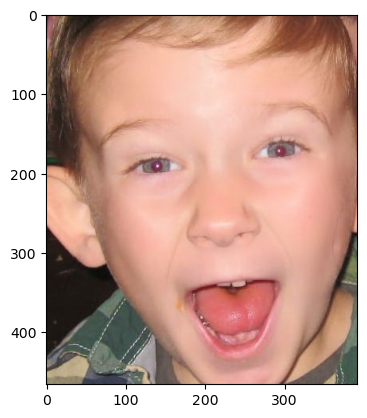

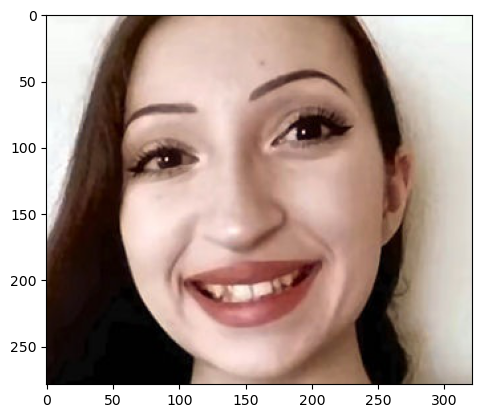

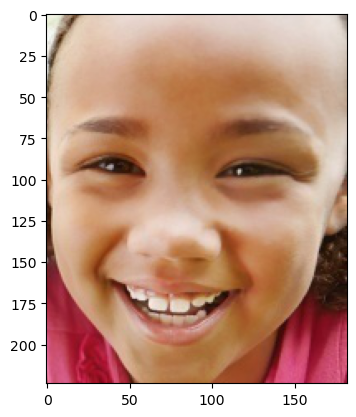

In [5]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [6]:
# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
    
    X = np.asarray(X)
    y = np.asarray(y)
    X = X.reshape(2540, 150*150*3)
            
    return X,y

In [7]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

In [8]:
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)

<Figure size 1200x800 with 0 Axes>

In [9]:
tsne = TSNE(random_state=42).fit_transform(X_train)

c:\Users\SAGAR\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\SAGAR\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [10]:
def visualise_tsne_3d(tsne_data, target):
    colour_map = []
    for i in target:
        if i == 1:
            colour_map.append('r')
        else:
            colour_map.append('b')

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*zip(*tsne), c=colour_map, s=30, alpha=1)
    legenditems = [(plt.Rectangle((0,0),1,1, color=c), "Non_Autistic" if str(i) == '0' else "Autistic") for i,c in enumerate(np.unique(colour_map))]
    plt.legend(*zip(*legenditems))
    plt.show()

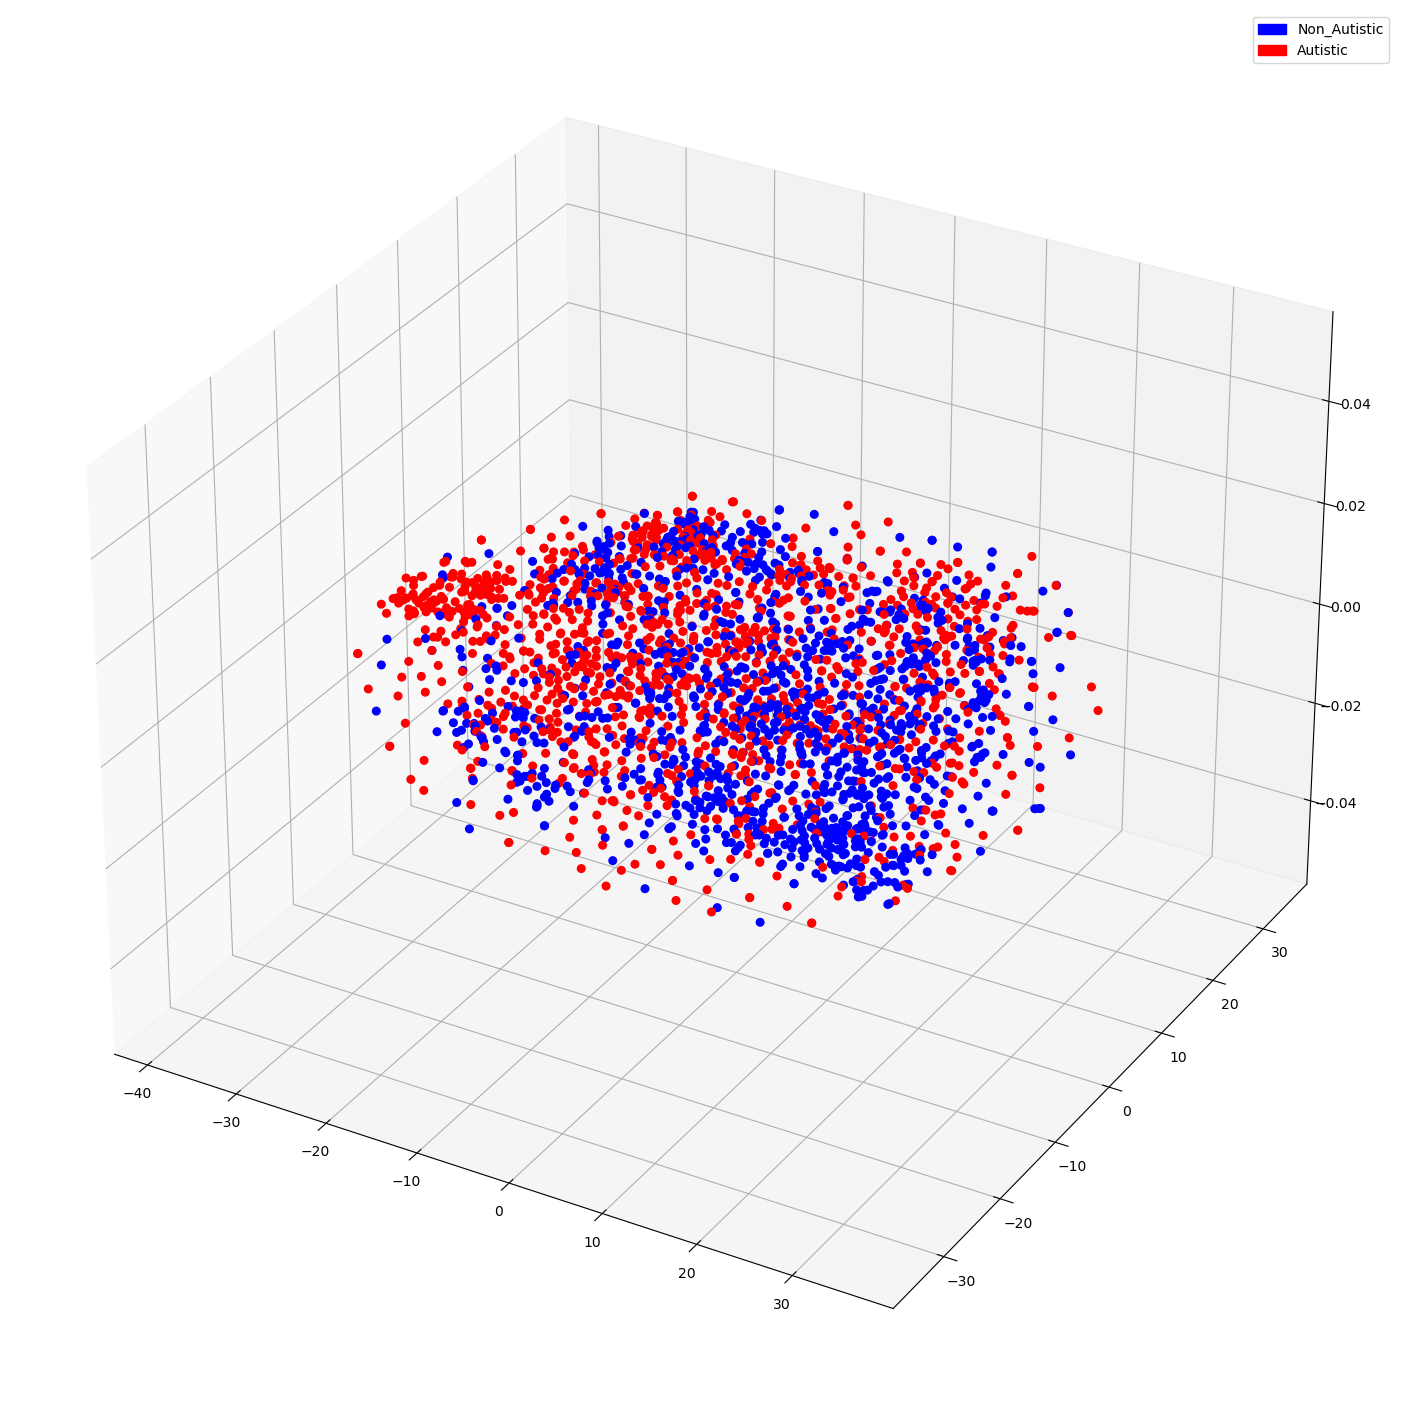

In [11]:
visualise_tsne_3d(tsne, y_train)

In [12]:
def visualise_tsne_images(tsne_data, train_images, labels):
    
    """Takes in tsne projections, plots distribution of images in 2 classes"""
    
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    image_paths = [train_images[i] for i in range(len(train_images))]
    #label = y_train

    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 4000
    height = 3000
    max_dim = 200

    full_image = Image.new('RGBA', (width, height))
    for img, x, y, label in zip(image_paths, tx, ty, labels):
        tile = Image.open(img)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        tile_height, tile_width = tile.size
        draw = ImageDraw.Draw(tile)
        draw.rectangle((0,0,tile_height-1,tile_width-1), fill=None, outline='blue' if label==0 else 'red', width=8)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*(1-y))), mask=tile.convert('RGBA'))   
    plt.figure(figsize = (30,28))
    plt.imshow(full_image)

c:\Users\SAGAR\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


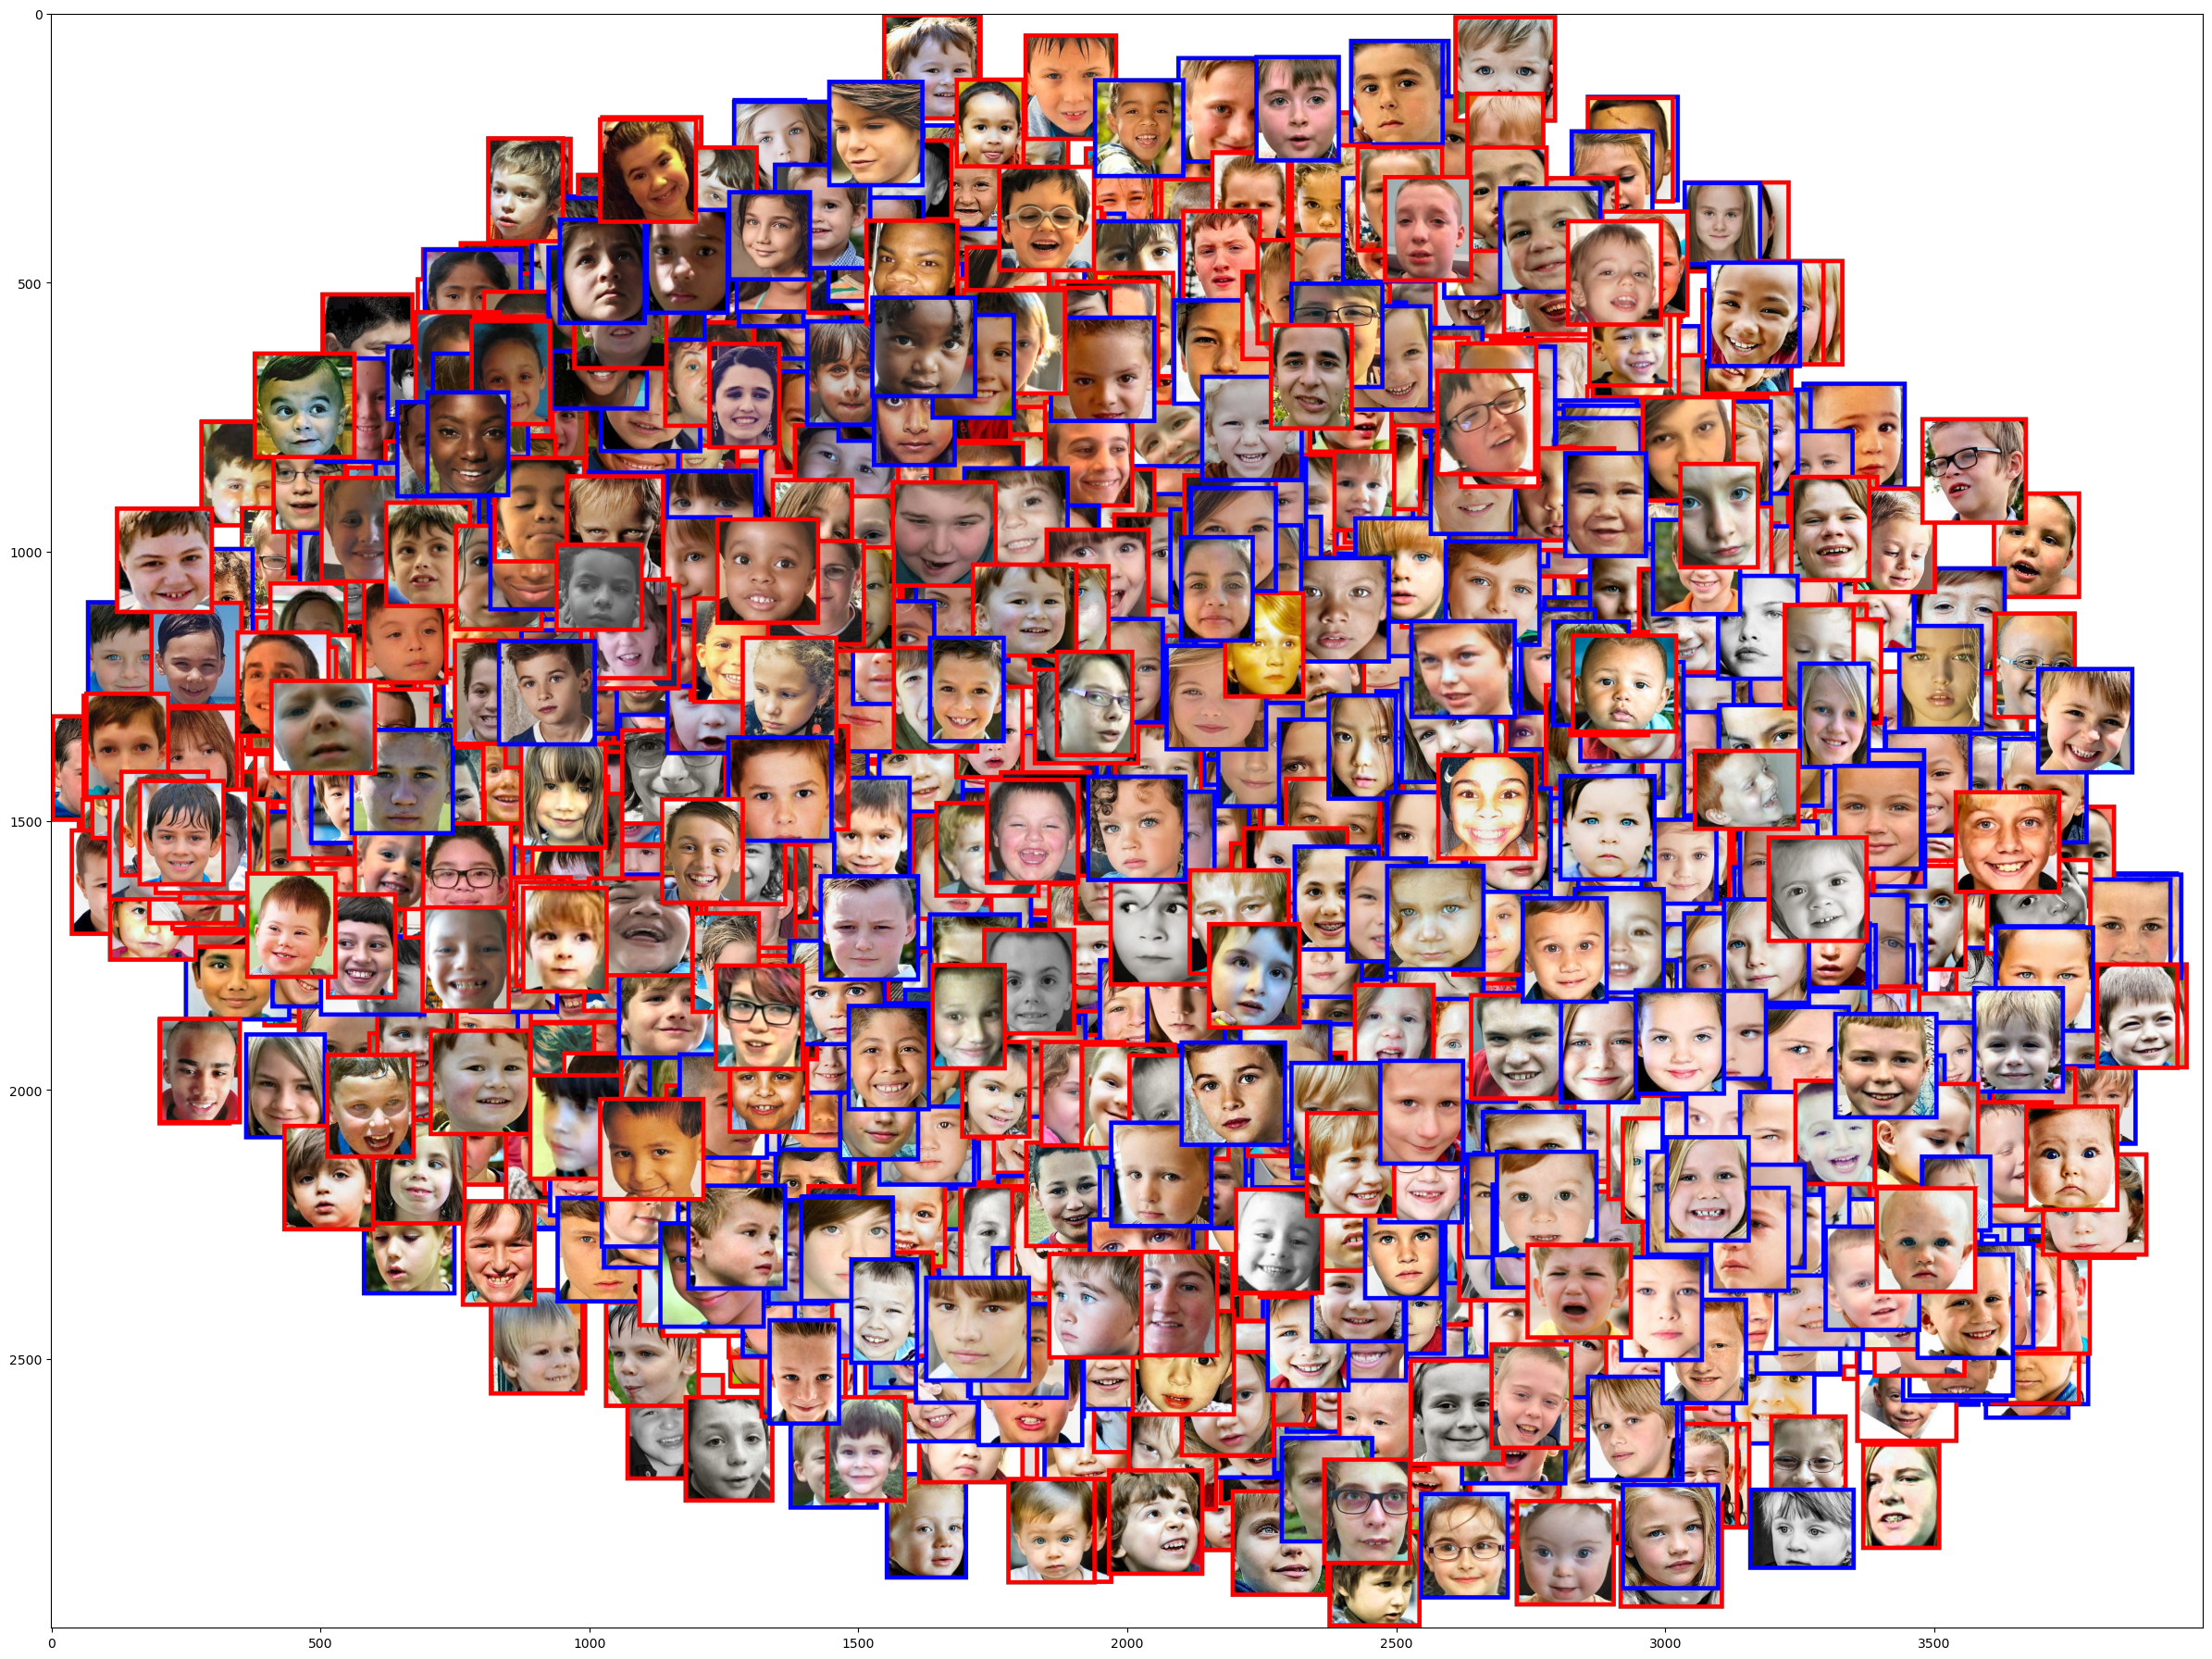

In [13]:
visualise_tsne_images(tsne, train_imgs, y_train)

In [14]:
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 67500)
Shape of train labels: (2540,)


In [15]:
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

In [16]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

In [17]:
# Convert the lists to array
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)

<Figure size 1200x800 with 0 Axes>

In [18]:
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [19]:
# Repeat the above process for validation data to get val_images
val_autistic = "../data/AutismDataset/valid/Autistic"
val_non_autistic = "../data/AutismDataset/valid/Non_Autistic"
val_autistic_imgs = ["../data/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["../data/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

13599

In [20]:
# Get resized images and labels from validation data
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

21

Text(0.5, 1.0, 'Validation image labels')

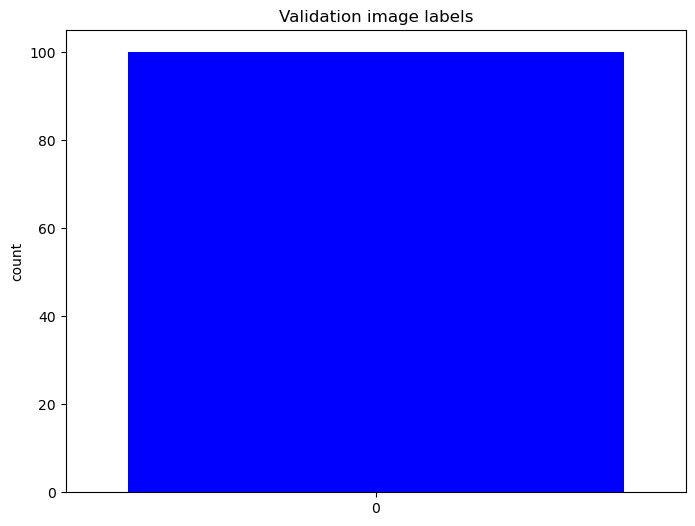

In [21]:
# Convert the lists to array
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(8,6 ))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

In [22]:
# Shape of validation images and labels
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [23]:
# Get length of train data and validation data
ntrain = len(X_train)
nval = len(X_val)
BATCH_SIZE = 32

In [24]:
x_train_tensor=torch.Tensor(X_train)
y_train_tensor=torch.Tensor(y_train)
x_val_tensor=torch.Tensor(X_val)
y_val_tensor=torch.Tensor(y_val)

In [25]:
x_train_tensor.shape

torch.Size([2540, 150, 150, 3])

In [26]:
x_train_tensor=torch.permute(x_train_tensor, (0, 3, 1, 2))
x_val_tensor=torch.permute(x_val_tensor,(0, 3, 1, 2))

In [27]:
x_val_tensor.shape
x_train_tensor.shape

torch.Size([2540, 3, 150, 150])

In [28]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset=TensorDataset(x_val_tensor,y_val_tensor)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE )
val_loader= DataLoader(val_dataset,batch_size=BATCH_SIZE)

In [31]:
resnetmodel = model.resnet18(pretrained=True)

#freeze all params
for params in resnetmodel.parameters():
  params.requires_grad_ = False

c:\Users\SAGAR\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\SAGAR\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\SAGAR/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:13<00:00, 3.50MB/s]


In [32]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
nr_filters = resnetmodel.fc.in_features  #number of input features of last layer
resnetmodel.fc = nn.Sequential(
   nn.Linear(nr_filters,206),
     nn.ReLU(),
     nn.Dropout(0.5),
     nn.Linear(206,1),
     nn.Sigmoid()
 )

resnetmodel = resnetmodel.to(device)

In [34]:
print(resnetmodel)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
# loss_fn=nn.BCELoss()
# optimizer=torch.optim.Adam(VGG16_model.parameters(),lr=0.01)
loss_fn=F.binary_cross_entropy
optimizer=torch.optim.Adam(resnetmodel.fc.parameters(),lr=0.01)

In [38]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [39]:
train_step = make_train_step(resnetmodel, optimizer, loss_fn)

In [40]:
for i,j in train_loader:
  out=resnetmodel(i)
  loss=loss_fn(out,j.unsqueeze(1).float())
  print(loss)
  break

tensor(0.7164, grad_fn=<BinaryCrossEntropyBackward0>)


In [41]:
from tqdm import tqdm
losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(train_loader),total=len(train_loader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(train_loader)
    losses.append(loss)

  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in val_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      resnetmodel.eval()

      yhat = resnetmodel(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(val_loader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))

    best_loss = min(epoch_test_losses)

    #save best model
    if cum_loss <= best_loss:
      best_model_wts = resnetmodel.state_dict()

    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training

#load best model
resnetmodel.load_state_dict(best_model_wts)

100%|██████████| 80/80 [03:43<00:00,  2.79s/it]



Epoch : 1, train loss : 0.7272270917892456
Epoch : 1, val loss : 0.6110580563545227


100%|██████████| 80/80 [03:40<00:00,  2.75s/it]



Epoch : 2, train loss : 0.5546997785568237
Epoch : 2, val loss : 0.5497164726257324


100%|██████████| 80/80 [03:39<00:00,  2.75s/it]



Epoch : 3, train loss : 0.5240456461906433
Epoch : 3, val loss : 0.4582996070384979


100%|██████████| 80/80 [03:46<00:00,  2.83s/it]



Epoch : 4, train loss : 0.544527530670166
Epoch : 4, val loss : 0.4628819525241852


100%|██████████| 80/80 [03:26<00:00,  2.58s/it]



Epoch : 5, train loss : 0.5356642007827759
Epoch : 5, val loss : 0.6482034921646118


100%|██████████| 80/80 [03:40<00:00,  2.76s/it]



Epoch : 6, train loss : 0.5270439982414246
Epoch : 6, val loss : 0.514606237411499


100%|██████████| 80/80 [08:12<00:00,  6.16s/it]



Epoch : 7, train loss : 0.5198518633842468
Epoch : 7, val loss : 0.6122450232505798


100%|██████████| 80/80 [08:41<00:00,  6.51s/it]



Epoch : 8, train loss : 0.5223989486694336
Epoch : 8, val loss : 0.37612441182136536


100%|██████████| 80/80 [04:32<00:00,  3.41s/it]



Epoch : 9, train loss : 0.5219957232475281
Epoch : 9, val loss : 0.37661707401275635


100%|██████████| 80/80 [04:33<00:00,  3.42s/it]



Epoch : 10, train loss : 0.5200583934783936
Epoch : 10, val loss : 0.469754695892334


<All keys matched successfully>

In [44]:
torch.save(resnetmodel.state_dict(),'autism_cnn.pth')

In [3]:
from torchvision.models.resnet import ResNet, BasicBlock

In [4]:
class ImageClassifier(ResNet):
    def __init__(self):
        super(ImageClassifier, self).__init__(BasicBlock, [2,2,2,2], num_classes=1)

        self.fc =  nn.Sequential(
                nn.Linear(512 * BasicBlock.expansion,206),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(206,1),
                nn.Sigmoid()
            )

model = ImageClassifier()

In [5]:
model.load_state_dict(torch.load("autism_cnn.pth"))
print(model)

ImageClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [6]:
nrows = 150
ncolumns  = 150
channels = 3

In [16]:
image='D:\\Hand-Classification-For-Autism-Diagnosis-main\\Hand-Classification-For-Autism-Diagnosis-main\\faceImage\\archive\\AutismDataset\\consolidated\\Autistic\\0001.jpg'
img=cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC)
tensor_img=torch.Tensor(img)
tensor_img.shape

torch.Size([150, 150, 3])

In [17]:
tensor_img=torch.permute(tensor_img, (2,0,1))

In [18]:
tensor_img=torch.unsqueeze(tensor_img,dim=0)
tensor_img.shape

torch.Size([1, 3, 150, 150])

In [19]:
model.eval()
preds=model(tensor_img)
print(preds)

tensor([[0.6820]], grad_fn=<SigmoidBackward0>)


In [20]:
preds.item()

0.6819571852684021